Exploratory data analysis
-------------------------------------

In [25]:
import os

from pprint import pprint
from itertools import chain

import numpy as np
import scipy as sp
from scipy import sparse
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (18,12)

import uproot

In [26]:
data_path = "/afs/cern.ch/user/a/ananiev/cernbox/data/"

In [27]:
datasets = {
    "GamGam": {
        "MC": [
            ("mc_341081.ttH125_gamgam.GamGam", {"tag": "tt"}),
            ("mc_343981.ggH125_gamgam.GamGam", {"tag": "gg"}),
            ("mc_345041.VBFH125_gamgam.GamGam", {"tag": "VBF"}),
            ("mc_345318.WpH125J_Wincl_gamgam.GamGam", {"tag": "WH"}),
            ("mc_345319.ZH125J_Zincl_gamgam.GamGam", {"tag": "ZH"})

        ]
    }
}

In [28]:
test_mc = uproot.open(os.path.join("root://", data_path, "GamGam", "MC", f"{datasets['GamGam']['MC'][0][0]}.root"))

In [29]:
test_mc_events = next(test_mc["mini"].iterate(["*"], entrystop=10000))

In [30]:
test_mc["mini"].keys()

[b'runNumber',
 b'eventNumber',
 b'channelNumber',
 b'mcWeight',
 b'scaleFactor_PILEUP',
 b'scaleFactor_ELE',
 b'scaleFactor_MUON',
 b'scaleFactor_PHOTON',
 b'scaleFactor_TAU',
 b'scaleFactor_BTAG',
 b'scaleFactor_LepTRIGGER',
 b'scaleFactor_PhotonTRIGGER',
 b'trigE',
 b'trigM',
 b'trigP',
 b'lep_n',
 b'lep_truthMatched',
 b'lep_trigMatched',
 b'lep_pt',
 b'lep_eta',
 b'lep_phi',
 b'lep_E',
 b'lep_z0',
 b'lep_charge',
 b'lep_type',
 b'lep_isTightID',
 b'lep_ptcone30',
 b'lep_etcone20',
 b'lep_trackd0pvunbiased',
 b'lep_tracksigd0pvunbiased',
 b'met_et',
 b'met_phi',
 b'jet_n',
 b'jet_pt',
 b'jet_eta',
 b'jet_phi',
 b'jet_E',
 b'jet_jvt',
 b'jet_trueflav',
 b'jet_truthMatched',
 b'jet_MV2c10',
 b'photon_n',
 b'photon_truthMatched',
 b'photon_trigMatched',
 b'photon_pt',
 b'photon_eta',
 b'photon_phi',
 b'photon_E',
 b'photon_isTightID',
 b'photon_ptcone30',
 b'photon_etcone20',
 b'photon_convType',
 b'tau_n',
 b'tau_pt',
 b'tau_eta',
 b'tau_phi',
 b'tau_E',
 b'tau_isTightID',
 b'tau_tru

In [31]:
def yield_files_with_meta(datasets):
    for process_name, process in datasets.items():
        print("Process: ", process_name)
        for type_name, thetype in process.items():
            print("Type: ", type_name)
            for filedata in thetype:
                try:
                    filename, meta = filedata
                except ValueError:
                    filename = filedata
                    meta = {}
                print("File: ", filename)
                fullpath = os.path.join("root://", data_path, process_name, type_name, f"{filename}.root")
                yield (process_name, type_name, filename), fullpath, meta

In [32]:
def dict_apply_mask(d, mask, fields=None):
    if fields is None:
        fields = d.keys()
    for f in fields:
        d[f] = d[f][mask]

In [33]:
def eta2tg_theta(eta):
    tg_theta = np.exp(-eta)
    tg_theta = 2*tg_theta**2/(1 - tg_theta**2)
    return tg_theta

In [34]:
def atlas_two_cosine(events, p1, p2):
    tg_theta_1 = eta2tg_theta(events[p1+b"_eta"])
    tg_theta_2 = eta2tg_theta(events[p2+b"_eta"])
    cos_delta_phi = np.cos(events[p2+b"_phi"] - events[p1+b"_phi"])
    return (cos_delta_phi + tg_theta_1*tg_theta_2)/np.sqrt((tg_theta_1**2 + 1)*(tg_theta_2**2 + 1))

In [35]:
def process_event_batch(events):
    batch
    return pd.DataFrame(batch)
    
#process_event_batch(test_events, bin_edges)

In [36]:
def events_per_file(datasets):
    entrysteps = 100000
    
    events = {}
    for (process, thetype, name), fullpath, meta in yield_files_with_meta(datasets):
        label = meta.get("tag") or f"{process}.{thetype}.{name}"
        with uproot.open(fullpath) as f:
            total_events = f["mini"].numentries
            print("Total Num Events: ", total_events)
            for i, data in enumerate(f["mini"].iterate(["*"], entrysteps=entrysteps)):
                print("Processing: ", (i+1)*entrysteps)
                events[label] = data
                break
    return events

In [37]:
events = events_per_file(datasets)

Process:  GamGam
Type:  MC
File:  mc_341081.ttH125_gamgam.GamGam
Total Num Events:  576491
Processing:  100000
File:  mc_343981.ggH125_gamgam.GamGam
Total Num Events:  1054711
Processing:  100000
File:  mc_345041.VBFH125_gamgam.GamGam
Total Num Events:  497468
Processing:  100000
File:  mc_345318.WpH125J_Wincl_gamgam.GamGam
Total Num Events:  113765
Processing:  100000
File:  mc_345319.ZH125J_Zincl_gamgam.GamGam
Total Num Events:  230900
Processing:  100000


In [38]:
events.keys()

dict_keys(['tt', 'gg', 'VBF', 'WH', 'ZH'])

In [39]:
def per_axis(func, events):
    fig, ax = plt.subplots(3, 2)
    ax_iter = chain.from_iterable(ax)
    main = next(ax_iter)
    for (key, val), the_ax in zip(events.items(), ax_iter):
        func(the_ax, key, val)
        func(main, key, val)
    main.set_title("total")

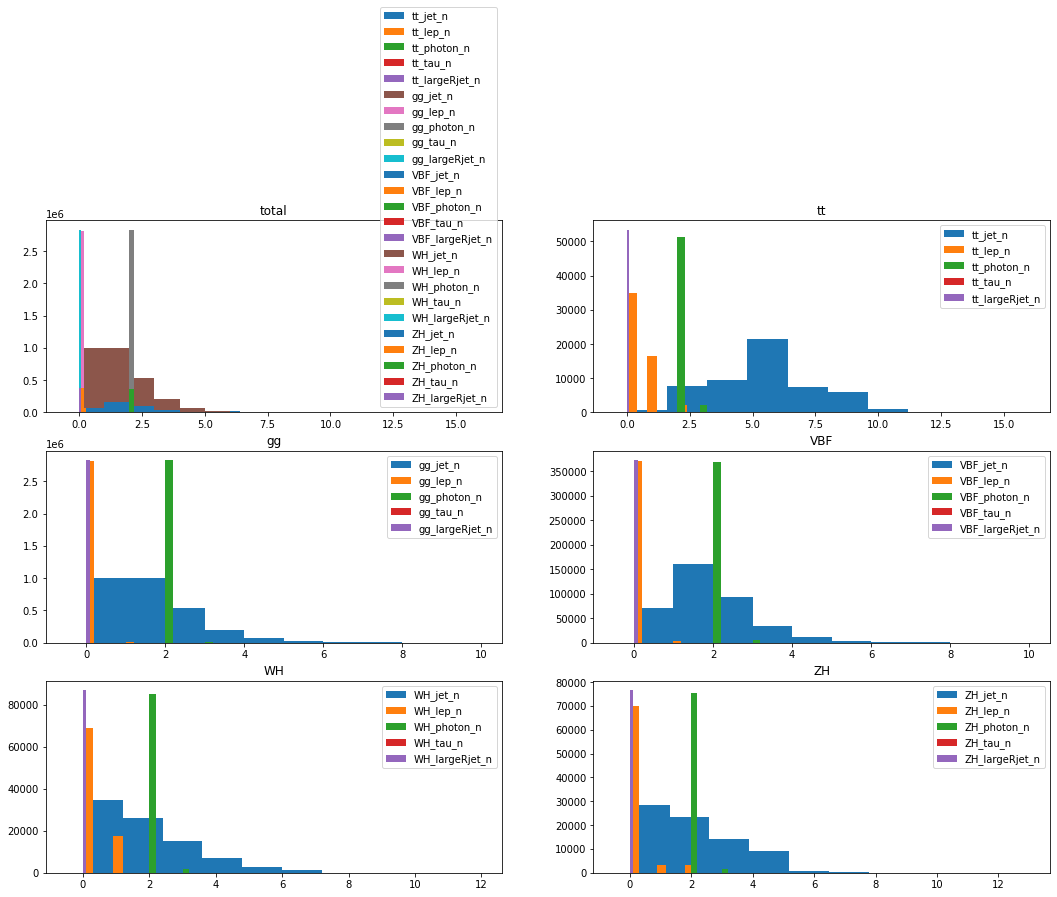

In [40]:
def plot_n_values(ax, key, events):
    ax.hist(events[b"jet_n"], weights=events[b"mcWeight"], label=f"{key}_jet_n")
    ax.hist(events[b"lep_n"], weights=events[b"mcWeight"], label=f"{key}_lep_n")
    ax.hist(events[b"photon_n"], weights=events[b"mcWeight"], label=f"{key}_photon_n")
    ax.hist(events[b"tau_n"], weights=events[b"mcWeight"], label=f"{key}_tau_n")
    ax.hist(events[b"largeRjet_n"], weights=events[b"mcWeight"], label=f"{key}_largeRjet_n")
    ax.legend()
    ax.set_title(key)
per_axis(plot_n_values, events)

/afs/cern.ch/user/a/ananiev/projects/venvs/sandbox/lib64/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/afs/cern.ch/user/a/ananiev/projects/venvs/sandbox/lib64/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


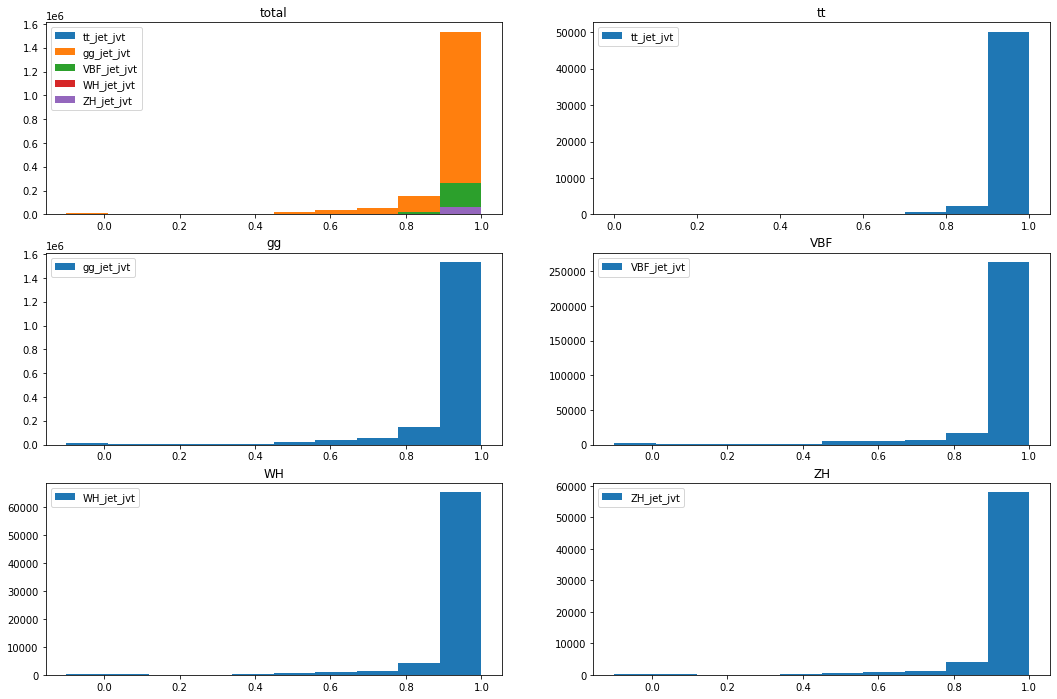

In [44]:
def plot_jet_jvt(ax, key, events):
    ax.hist(events[b"jet_jvt"].mean(), weights=events[b"mcWeight"], label=f"{key}_jet_jvt")
    ax.legend()
    ax.set_title(key)
per_axis(plot_jet_jvt, events)

/afs/cern.ch/user/a/ananiev/projects/venvs/sandbox/lib64/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/afs/cern.ch/user/a/ananiev/projects/venvs/sandbox/lib64/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


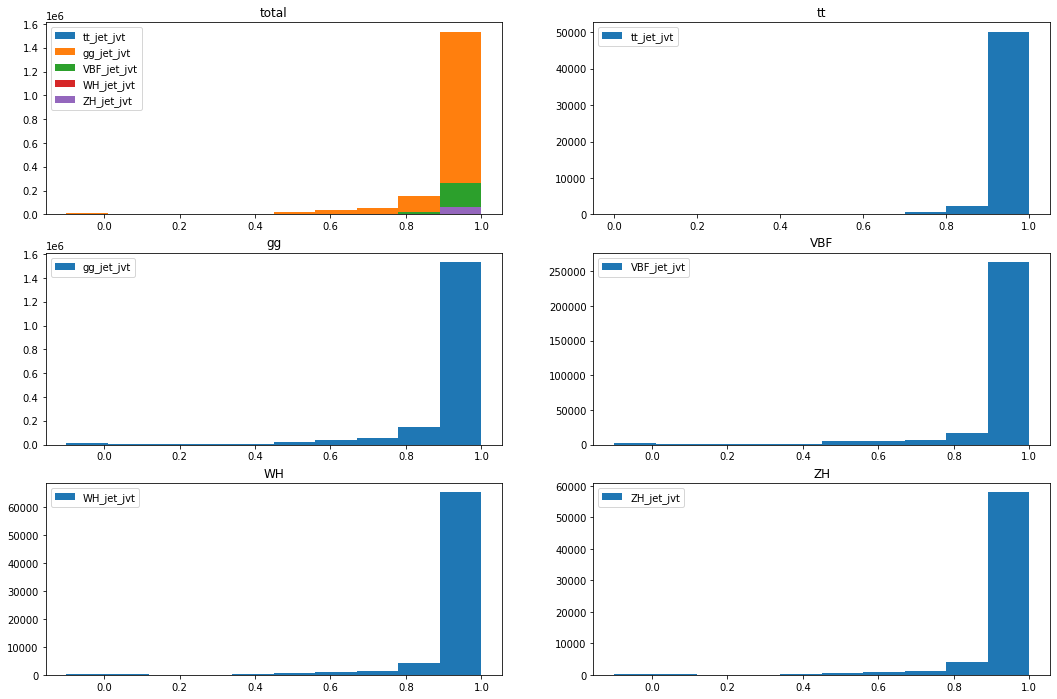

In [44]:
def plot_jet_jvt(ax, key, events):
    ax.hist(events[b"jet_jvt"].mean(), weights=events[b"mcWeight"], label=f"{key}_jet_jvt")
    ax.legend()
    ax.set_title(key)
per_axis(plot_jet_jvt, events)

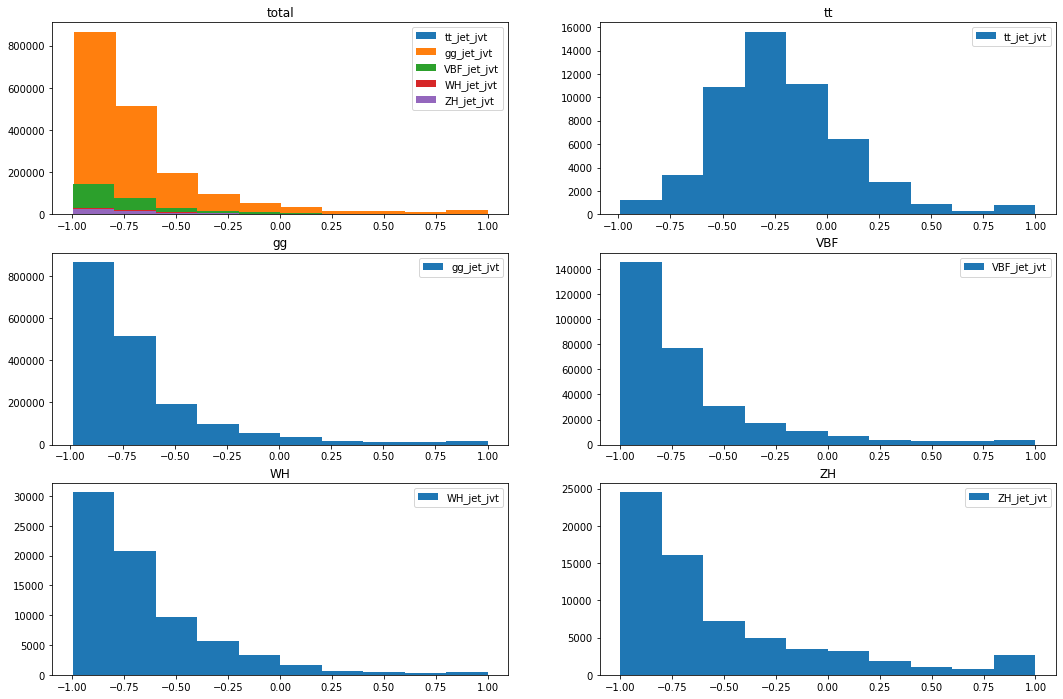

In [72]:
def plot_jet_MV2c10(ax, key, events):
    ax.hist(events[b"jet_MV2c10"].mean(), weights=events[b"mcWeight"], label=f"{key}_jet_jvt")
    ax.legend()
    ax.set_title(key)
per_axis(plot_jet_MV2c10, events)

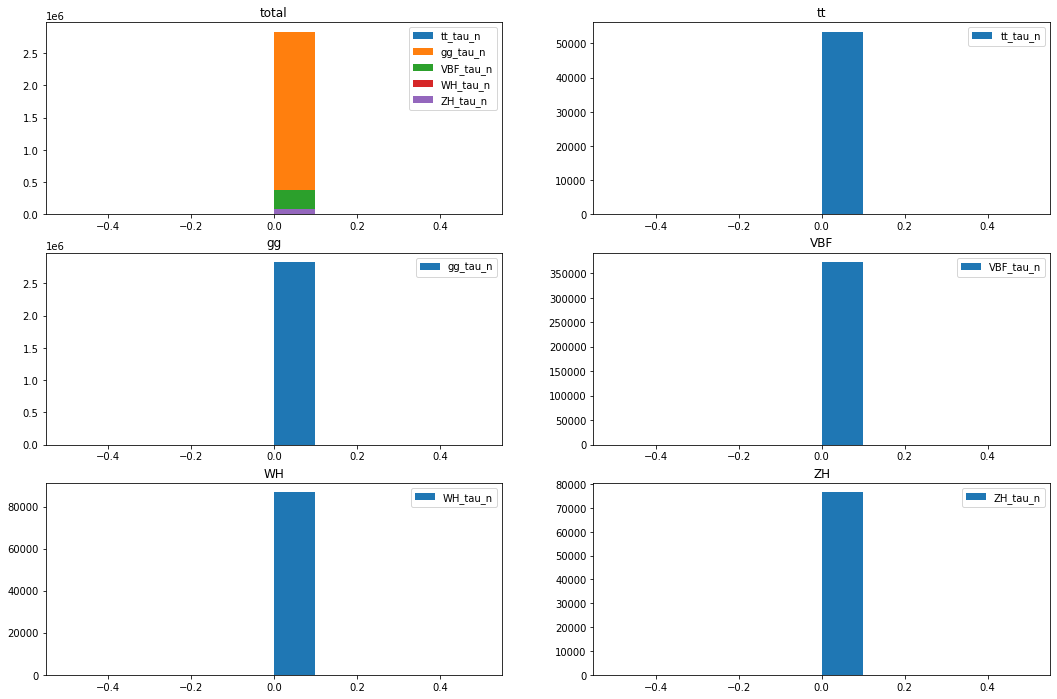

In [76]:
def plot_tau_n(ax, key, events):
    ax.hist(events[b"tau_n"], weights=events[b"mcWeight"], label=f"{key}_tau_n")
    ax.legend()
    ax.set_title(key)
per_axis(plot_tau_n, events)

In [78]:
test_mc_events[b"lep_charge"]

<JaggedArray [[-1] [-1] [] ... [-1] [] [-1 1]] at 0x7f8c76978be0>